Для начала, посмотрим на качество прогноза, предсказывая по 5 дней, и не используя дополнительного признакового пространства, а только лаги.

In [1]:
import pandas as pd
import os
import tensorflow as tf

from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout, GRU, Bidirectional
import math
from sklearn.metrics import mean_squared_error

from keras.layers import GRU,CuDNNGRU
from keras import optimizers
from keras.layers import TimeDistributed
from sklearn.preprocessing import MinMaxScaler

from matplotlib import pyplot as plt
import matplotlib
from matplotlib import gridspec

from sklearn.ensemble import GradientBoostingRegressor
import copy
import numpy as np

/Users/user/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/Users/user/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/Users/user/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/Users/user/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.

In [2]:
def plot_double(pred, true, roll_days=30):
    
    mae=np.abs(true-pred).shift(1).rolling(roll_days).mean()#.dropna()
    with plt.style.context('seaborn-white'):
        font = {'family': 'normal','weight': 'bold'}
        matplotlib.rc('font', **font)
        plt.figure(figsize=(17, 12))
        plt.subplots_adjust(wspace=0, hspace=0.4)
        gs = gridspec.GridSpec(5, 1)
        ax1 = plt.subplot(gs[:2, :])
        ax2 = plt.subplot(gs[2, :], sharex=ax1) 
        ax1.plot(pred/1e3, label='Prediction ')
        ax1.plot(true/1e3, label='Actual', color='r')
        ax2.plot(mae, color='#443f3e', label='MAE')
        ax2.set_title('MAE скользящее за {} дней '.format(roll_days), fontweight="bold")
        ax1.set_ylabel('тысяч рублей')
        #    plt.fill_between(x=range(0,len(model.result)), y1=model.UpperBond, y2=model.LowerBond, alpha=0.5, color = "grey")
        ax1.set_xticks([])
        ax2.set_xticks([])

        ax1.legend()
        ax2.legend()
        ax1.grid(True)
        ax2.grid(True)
        plt.show()

In [3]:
data = pd.read_csv('new_data.csv')

In [4]:
data.head()

,Unnamed: 0,weekday_0,weekday_1,weekday_2,weekday_3,weekday_4,weekday_5,weekday_6,month_1,month_2,...,mean,std,median,max,min,20_число,21_число,22_число,23_число,y
0,2015-01-01,0,0,0,1,0,0,0,1,0,...,NaN,NaN,NaN,NaN,NaN,0,0,0,0,213400.0
1,2015-01-02,0,0,0,0,1,0,0,1,0,...,NaN,NaN,NaN,NaN,NaN,0,0,0,0,94500.0
2,2015-01-03,0,0,0,0,0,1,0,1,0,...,NaN,NaN,NaN,NaN,NaN,0,0,0,0,63900.0
3,2015-01-04,0,0,0,0,0,0,1,1,0,...,NaN,NaN,NaN,NaN,NaN,0,0,0,0,134900.0
4,2015-01-05,1,0,0,0,0,0,0,1,0,...,NaN,NaN,NaN,NaN,NaN,0,0,0,0,99800.0


In [5]:
data = data.set_index('Unnamed: 0')

In [6]:
#sess = tf.compat.v1.Session(config=tf.compat.v1.ConfigProto(log_device_placement=True))
#tf.compat.v1.keras.backend.set_session(sess)

In [7]:
window = 40
dropout = 0.3
units = 128
lr = 1e-4
epochs = 100

test_size = 200


In [8]:
timeseries = copy.deepcopy(data)

In [9]:
timeseries = timeseries.dropna()

In [10]:
timeseries.head()

,weekday_0,weekday_1,weekday_2,weekday_3,weekday_4,weekday_5,weekday_6,month_1,month_2,month_3,...,mean,std,median,max,min,20_число,21_число,22_число,23_число,y
Unnamed: 0,,,,,,,,,,,,,,,,,,,,,
2015-01-08,0,0,0,1,0,0,0,1,0,0,...,115700.000000,49549.806592,99800.0,213400.0,63900.0,0,0,0,0,117900.0
2015-01-09,0,0,0,0,1,0,0,1,0,0,...,102057.142857,25455.049083,99800.0,134900.0,63900.0,0,0,0,0,165000.0
2015-01-10,0,0,0,0,0,1,0,1,0,0,...,112128.571429,34356.984457,117900.0,165000.0,63900.0,0,0,0,0,118900.0
2015-01-11,0,0,0,0,0,0,1,1,0,0,...,119985.714286,26988.048501,118900.0,165000.0,78900.0,0,0,0,0,75100.0
2015-01-12,1,0,0,0,0,0,0,1,0,0,...,111442.857143,30690.816061,117900.0,165000.0,75100.0,0,0,0,0,130600.0


In [11]:
training_set = timeseries.iloc[:-test_size].values
test_set = timeseries.iloc[-test_size:].values
scaler = MinMaxScaler(feature_range=(-1,1))
training_set_scaled = scaler.fit_transform(training_set)

In [12]:
X_train = []
y_train = []
for i in range(window,len(training_set)):
    X_train.append(training_set_scaled[i-window:i,:-1])
    y_train.append(training_set_scaled[i,-1])
X_train, y_train = np.array(X_train), np.array(y_train)

In [13]:
len(y_train)

744

In [14]:
len(X_train)

744

In [15]:
X_train[300][0]

array([-1.        , -1.        ,  1.        , -1.        , -1.        ,
       -1.        , -1.        , -1.        , -1.        , -1.        ,
       -1.        , -1.        , -1.        , -1.        , -1.        ,
       -1.        , -1.        ,  1.        , -1.        , -1.        ,
       -1.        , -1.        ,  1.        , -0.70500846, -0.89490889,
       -0.58030444, -0.85464796, -0.74689141, -1.        , -1.        ,
       -1.        , -1.        ])

In [16]:
y_train[300]

-0.9737925356750823

In [17]:
regressor = Sequential()
regressor.add(GRU(units=units,return_sequences=True, input_shape=(X_train.shape[1],X_train.shape[2])))
regressor.add(Dropout(dropout))


regressor.add(GRU(units=units))
regressor.add(Dropout(dropout))
regressor.add(Dense(units=1))

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
keep_dims is deprecated, use keepdims instead
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


In [18]:
batch_size=40

In [19]:
opt=optimizers.Adam(lr=lr)
regressor.compile(optimizer=opt,loss='mse')

history=regressor.fit(X_train,y_train,epochs=epochs,batch_size=batch_size,\
                      verbose=0,shuffle=False)    

Instructions for updating:
Use tf.cast instead.


In [20]:
inputs = timeseries[len(timeseries)-len(test_set) - window:].values
inputs  = scaler.transform(inputs)
X_test = []
for i in range(window,len(inputs)):
    X_test.append(inputs[i-window:i,:-1])

In [21]:
X_test = np.array(X_test)
predicted = regressor.predict(X_test)

In [22]:
predicted = scaler.inverse_transform(np.hstack((inputs[window:,:-1],\
                            predicted)))[:,-1]

In [23]:
pred=pd.Series(predicted,index=timeseries[-test_size:].index)
true=timeseries.iloc[-test_size:,-1]

In [24]:
from sklearn.metrics import mean_absolute_error

/Users/user/anaconda3/lib/python3.7/site-packages/matplotlib/font_manager.py:1241: UserWarning: findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.
  (prop.get_family(), self.defaultFamily[fontext]))


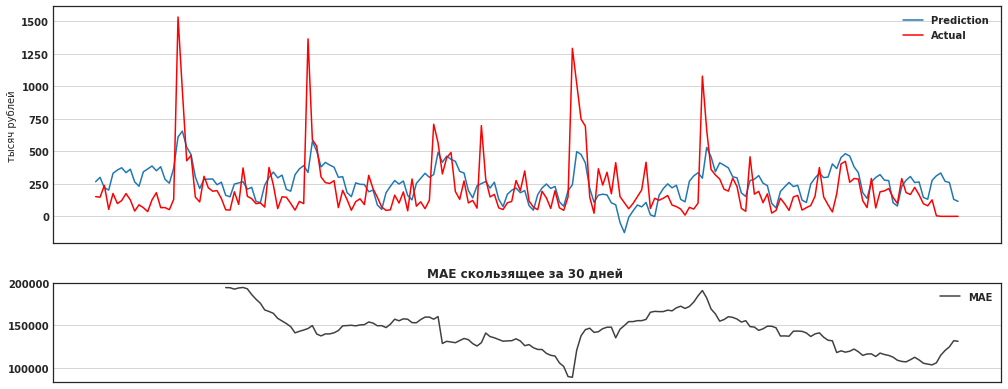

In [25]:
plot_double(pred,true)

In [26]:
pred_many_to_one = copy.deepcopy(pred)

In [27]:
true_many_to_one = copy.deepcopy(true)

# boosting

In [28]:
import OstrovPackPrediction
import imp
imp.reload(OstrovPackPrediction)
from OstrovPackPrediction import AnomalyDetector, OstrovPredictor
from OstrovPackPrediction import *
import calendar

In [29]:
pred = OstrovPredictor(model=GradientBoostingRegressor(random_state=42),backward_window_size=365,\
              forward_window_size=1,add_features_table=timeseries.iloc[:,:-1],auto_lags=True)
y, yhat,_ = pred.predict(timeseries=timeseries.iloc[:,-1])
results = pd.DataFrame({'факт': y, 'прогноз':yhat})

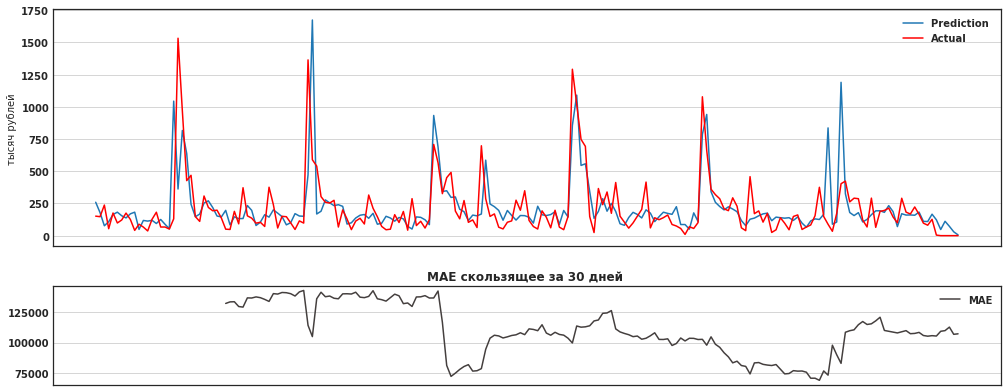

In [30]:
plot_double(results['прогноз'][-200:],results['факт'][-200:])

In [31]:
pred_boosting = copy.deepcopy(results['прогноз'][-200:])

In [32]:
true_boosting = copy.deepcopy(results['факт'][-200:])

# А теперь другой вариант many-to-many

In [33]:
window = 20
dropout = 0.3
units = 128
lr = 1e-3
epochs = 10
test_size = 200


In [34]:
import copy
import numpy as np

In [35]:
timeseries = copy.deepcopy(data)

In [36]:
timeseries['true'] = timeseries['y'].shift(-1)

In [37]:
timeseries = timeseries.dropna()

In [38]:
timeseries.head()

,weekday_0,weekday_1,weekday_2,weekday_3,weekday_4,weekday_5,weekday_6,month_1,month_2,month_3,...,std,median,max,min,20_число,21_число,22_число,23_число,y,true
Unnamed: 0,,,,,,,,,,,,,,,,,,,,,
2015-01-08,0,0,0,1,0,0,0,1,0,0,...,49549.806592,99800.0,213400.0,63900.0,0,0,0,0,117900.0,165000.0
2015-01-09,0,0,0,0,1,0,0,1,0,0,...,25455.049083,99800.0,134900.0,63900.0,0,0,0,0,165000.0,118900.0
2015-01-10,0,0,0,0,0,1,0,1,0,0,...,34356.984457,117900.0,165000.0,63900.0,0,0,0,0,118900.0,75100.0
2015-01-11,0,0,0,0,0,0,1,1,0,0,...,26988.048501,118900.0,165000.0,78900.0,0,0,0,0,75100.0,130600.0
2015-01-12,1,0,0,0,0,0,0,1,0,0,...,30690.816061,117900.0,165000.0,75100.0,0,0,0,0,130600.0,139500.0


In [39]:
timeseries.shape

(983, 34)

In [40]:
training_set = timeseries.iloc[:-test_size].values
test_set = timeseries.iloc[-test_size:].values
scaler = MinMaxScaler(feature_range=(0,1))
training_set_scaled = scaler.fit_transform(training_set)

In [41]:
steps = len(training_set)//window+1

In [42]:
X_train = []
y_train = []
for i in range(steps):
    X = training_set_scaled[i*window:(i+1)*window,:-1]
    X = X.reshape(1,X.shape[0],X.shape[1])
    X_train.append(X)
    y = training_set_scaled[i*window:(i+1)*window,-1]
    y = y.reshape(1,y.shape[0],1)
    y_train.append(y)


In [43]:
len(X_train)

40

In [44]:
len(y_train)

40

In [45]:
X_train[0].shape

(1, 20, 33)

In [46]:
y_train[0].shape

(1, 20, 1)

In [47]:
regressor = Sequential()
regressor.add(GRU(units=units, \
                       return_sequences=True, input_shape=(None,X_train[0].shape[2])))
regressor.add(Dropout(dropout))


regressor.add(GRU(units=units,return_sequences=True))
regressor.add(Dropout(dropout))

regressor.add(TimeDistributed(Dense(1)))

In [48]:
def train_generator():
    while True:
        for key in range(len(X_train)):
            yield (X_train[key],y_train[key])

In [50]:
opt=optimizers.Adam(lr=lr)
regressor.compile(optimizer=opt,loss='mse')

history=regressor.fit(train_generator(), steps_per_epoch=40, epochs=100, verbose=0,shuffle=False)    

TypeError: Error when checking model input: data should be a Numpy array, or list/dict of Numpy arrays. Found: <generator object train_generator at 0x7ff235591f48>...

In [ ]:
#from keras import backend as back

In [ ]:
#back.clear_session()

In [ ]:
inputs  = scaler.transform(test_set)

In [ ]:
steps = len(inputs)//window+1

In [ ]:
X_test = []
y_test = []
for i in range(steps):
    X = inputs[i*window:(i+1)*window,:-1]
    if len(X)==0:
        break
    X = X.reshape(1,X.shape[0],X.shape[1])
    X_test.append(X)
    y = inputs[i*window:(i+1)*window,-1]
    y = y.reshape(1,y.shape[0],1)
    y_test.append(y)


In [ ]:
preds = []

In [ ]:
for q in range(len(X_test)):
    
    pred = regressor.predict(X_test[q])
    pred = scaler.inverse_transform(np.hstack((X_test[q][0],\
                            pred[0])))[:,-1]
    preds.append(pred)

In [ ]:
pred=pd.Series(np.hstack(preds),index=timeseries[-test_size:].index)
true=timeseries.iloc[-test_size:,-1]

In [ ]:
plot_double(pred,true)

In [ ]:
pred_many_to_many = copy.deepcopy(pred)

In [ ]:
true_many_to_many = copy.deepcopy(true)

In [ ]:
from sklearn.metrics import mean_absolute_error

In [ ]:
mean_absolute_error(pred,true)

# сравнение

In [ ]:
def confidence_bands(series):
    n_days=len(series)
    intervals=np.linspace(0,15e4,1001)
    ths=list()
    for interval in intervals:
        k=0
        for d in range(n_days):
            if np.abs(series[d])<interval:
                k+=1
        ths.append(k/n_days*100)
    area=0
    for q in ths[1:]:
        area+=q*150
    return [intervals,ths],area/(100*15e4)*100

In [ ]:
model_predictions = {'many_to_one':pred_many_to_one,'many_to_many':pred_many_to_many,'boosting':pred_boosting}
model_true= {'many_to_one':true_many_to_one,'many_to_many':true_many_to_many,'boosting':true_boosting}

In [ ]:
fig, axes = plt.subplots(figsize=(10,5))
for i in model_predictions:
    coordinates,area=confidence_bands(model_true[i]-model_predictions[i])
    axes.plot(coordinates[0],coordinates[1],label=i+' area under curve  : '+str(round(area,3))+'%')
    axes.set_ylabel('TH%',fontsize=14)
    axes.legend()
plt.show()

In [ ]:
from sklearn.metrics import mean_absolute_error